# Translator Classification - SVM

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch

if torch.cuda.is_available():
  dev = "cuda"
else:
  dev = "cpu"
device = torch.device(dev)

print(device)

cuda


In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
import pandas
import numpy as np
from sklearn import svm
from matplotlib import pyplot as plt
from operator import itemgetter

In [4]:
import pandas as pd 

train_df = pd.read_pickle("/home/kkatsy/litMT/experiment_dataset/aligned_train_df.pickle")  
test_df = pd.read_pickle("/home/kkatsy/litMT/experiment_dataset/experiment_test_df.pickle") 
val_df = pd.read_pickle("/home/kkatsy/litMT/experiment_dataset/experiment_val_df.pickle") 

print('train size: ', train_df.shape)
print('val size: ', val_df.shape)
print('test size: ', test_df.shape)

sentences = {}
sentences['train'] = [{'label': row['labels'], 'text':row['concat']} for i, row in train_df.iterrows()]
sentences['test'] = [{'label': row['labels'], 'text':row['concat']} for i, row in test_df.iterrows()]
sentences['val'] = [{'label': row['labels'], 'text':row['concat']} for i, row in val_df.iterrows()]

print('train size: ', len(sentences['train']))
print('val size: ', len(sentences['val']))
print('test size: ', len(sentences['test']))

train size:  (17735, 8)
val size:  (1175, 8)
test size:  (1175, 8)
train size:  17735
val size:  1175
test size:  1175


In [5]:
BERT_MODEL = "bert-base-multilingual-cased"

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

In [6]:
import datasets
import pandas as pd

train_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=sentences['train']))
val_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=sentences['val']))
test_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=sentences['test']))

### TGT 512

In [7]:
tfidf_tok_512 = TfidfVectorizer(ngram_range=(1,2))
clf_512 = svm.SVC(kernel='linear')

In [8]:
def preprocess_function_512(datum):
    src, tgt = datum['text'].split(' <SEP> ')
    return tokenizer(tgt, padding='max_length', max_length=512, truncation='longest_first')

tokenized_train_512 = train_dataset.map(preprocess_function_512)
tokenized_val_512 = val_dataset.map(preprocess_function_512)
tokenized_test_512 = test_dataset.map(preprocess_function_512)

Map:   0%|          | 0/17735 [00:00<?, ? examples/s]

Map:   0%|          | 0/1175 [00:00<?, ? examples/s]

Map:   0%|          | 0/1175 [00:00<?, ? examples/s]

In [9]:
train_decoded_512 = [tokenizer.decode(datum['input_ids']) for datum in tokenized_train_512]
train_labels = [datum['label'] for datum in tokenized_train_512]
val_decoded_512 = [tokenizer.decode(datum['input_ids']) for datum in tokenized_val_512]
val_labels = [datum['label'] for datum in tokenized_val_512]
test_decoded_512 = [tokenizer.decode(datum['input_ids']) for datum in tokenized_test_512]
test_labels = [datum['label'] for datum in tokenized_test_512]

2024-03-06 11:55:46.417532: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
train_tfidf_512 = tfidf_tok_512.fit_transform(train_decoded_512)
val_tfidf_512 = tfidf_tok_512.transform(val_decoded_512)
test_tfidf_512 = tfidf_tok_512.transform(test_decoded_512)

In [11]:
clf_512.fit(train_tfidf_512, train_labels)

SVC(kernel='linear')

In [12]:
label_pred_val_512 = clf_512.predict(val_tfidf_512)

In [13]:
print("Val Accuracy:",metrics.accuracy_score(val_labels, label_pred_val_512))
print("Val F1:",metrics.f1_score(val_labels, label_pred_val_512, average='weighted'))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Val Precision:",metrics.precision_score(val_labels, label_pred_val_512, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Val Recall:",metrics.recall_score(val_labels, label_pred_val_512, average='weighted'))

Val Accuracy: 0.23063829787234041
Val F1: 0.14357974665246662
Val Precision: 0.3970418392002164
Val Recall: 0.23063829787234041


In [14]:
label_pred_test_512 = clf_512.predict(test_tfidf_512)

In [15]:
print("Test Accuracy:",metrics.accuracy_score(test_labels, label_pred_test_512))
print("Test F1:",metrics.f1_score(test_labels, label_pred_val_512, average='weighted'))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Test Precision:",metrics.precision_score(test_labels, label_pred_test_512, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Test Recall:",metrics.recall_score(test_labels, label_pred_test_512, average='weighted'))

Test Accuracy: 0.2246808510638298
Test F1: 0.10982467521318465
Test Precision: 0.39736736602966727
Test Recall: 0.2246808510638298


<Axes: title={'center': 'Tgt 512: Top 30 Features'}>

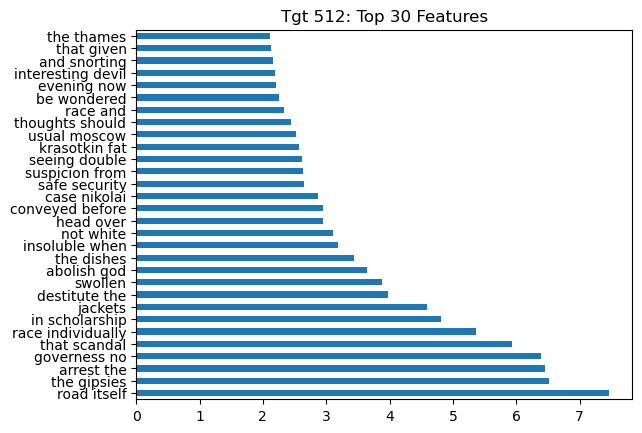

In [16]:
pd.Series(abs(clf_512.coef_.toarray()[0]), index=tfidf_tok_512.vocabulary_).nlargest(30).plot(kind='barh', title='Tgt 512: Top 30 Features')


### TGT 256

In [17]:
tfidf_tok_256 = TfidfVectorizer(ngram_range=(1,2))
clf_256 = svm.SVC(kernel='linear')

In [18]:
def preprocess_function_256(datum):
    src, tgt = datum['text'].split(' <SEP> ')
    return tokenizer(tgt, padding='max_length', max_length=256, truncation='longest_first')

tokenized_train_256 = train_dataset.map(preprocess_function_256)
tokenized_val_256 = val_dataset.map(preprocess_function_256)
tokenized_test_256 = test_dataset.map(preprocess_function_256)

Map:   0%|          | 0/17735 [00:00<?, ? examples/s]

Map:   0%|          | 0/1175 [00:00<?, ? examples/s]

Map:   0%|          | 0/1175 [00:00<?, ? examples/s]

In [19]:
train_decoded_256 = [tokenizer.decode(datum['input_ids']) for datum in tokenized_train_256]
train_labels = [datum['label'] for datum in tokenized_train_256]
val_decoded_256 = [tokenizer.decode(datum['input_ids']) for datum in tokenized_val_256]
val_labels = [datum['label'] for datum in tokenized_val_256]
test_decoded_256 = [tokenizer.decode(datum['input_ids']) for datum in tokenized_test_256]
test_labels = [datum['label'] for datum in tokenized_test_256]

In [20]:
train_tfidf_256 = tfidf_tok_256.fit_transform(train_decoded_256)
val_tfidf_256 = tfidf_tok_256.transform(val_decoded_256)
test_tfidf_256 = tfidf_tok_256.transform(test_decoded_256)

In [21]:
clf_256.fit(train_tfidf_256, train_labels)

SVC(kernel='linear')

In [22]:
label_pred_val_256 = clf_256.predict(val_tfidf_256)

In [23]:
print("Val Accuracy:",metrics.accuracy_score(val_labels, label_pred_val_256))
print("Val F1:",metrics.f1_score(val_labels, label_pred_val_256, average='weighted'))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Val Precision:",metrics.precision_score(val_labels, label_pred_val_256, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Val Recall:",metrics.recall_score(val_labels, label_pred_val_256, average='weighted'))

Val Accuracy: 0.2663829787234043
Val F1: 0.2092331632449042
Val Precision: 0.43494530057647657
Val Recall: 0.2663829787234043


In [24]:
label_pred_test_256 = clf_256.predict(test_tfidf_256)

In [25]:
print("Test Accuracy:",metrics.accuracy_score(test_labels, label_pred_test_256))
print("Test F1:",metrics.f1_score(test_labels, label_pred_test_256, average='weighted'))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Test Precision:",metrics.precision_score(test_labels, label_pred_test_256, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Test Recall:",metrics.recall_score(test_labels, label_pred_test_256, average='weighted'))

Test Accuracy: 0.2502127659574468
Test F1: 0.18842823948737616
Test Precision: 0.39486994039842227
Test Recall: 0.2502127659574468


<Axes: title={'center': 'Tgt 256: Top 30 Features'}>

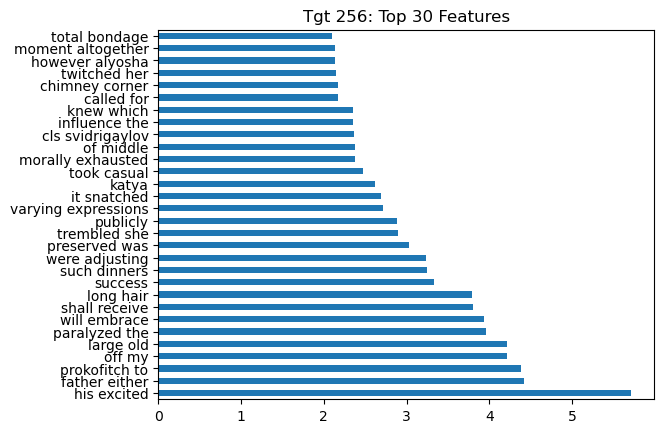

In [26]:
pd.Series(abs(clf_256.coef_.toarray()[0]), index=tfidf_tok_256.vocabulary_).nlargest(30).plot(kind='barh', title='Tgt 256: Top 30 Features')

### SRC + TGT

In [27]:
tfidf_tok_concat = TfidfVectorizer(ngram_range=(1,2))
clf_concat = svm.SVC(kernel='linear')

In [28]:
def preprocess_function_concat(datum):
    src, tgt = datum['text'].split(' <SEP> ')
    return tokenizer(src, tgt, padding='max_length', max_length=512, truncation='longest_first')

tokenized_train_concat = train_dataset.map(preprocess_function_concat)
tokenized_val_concat = val_dataset.map(preprocess_function_concat)
tokenized_test_concat = test_dataset.map(preprocess_function_concat)

Map:   0%|          | 0/17735 [00:00<?, ? examples/s]

Map:   0%|          | 0/1175 [00:00<?, ? examples/s]

Map:   0%|          | 0/1175 [00:00<?, ? examples/s]

In [29]:
train_decoded_concat = [tokenizer.decode(datum['input_ids']) for datum in tokenized_train_concat]
train_labels = [datum['label'] for datum in tokenized_train_concat]
val_decoded_concat = [tokenizer.decode(datum['input_ids']) for datum in tokenized_val_concat]
val_labels = [datum['label'] for datum in tokenized_val_concat]
test_decoded_concat = [tokenizer.decode(datum['input_ids']) for datum in tokenized_test_concat]
test_labels = [datum['label'] for datum in tokenized_test_concat]

In [30]:
train_tfidf_concat = tfidf_tok_concat.fit_transform(train_decoded_concat)
val_tfidf_concat = tfidf_tok_concat.transform(val_decoded_concat)
test_tfidf_concat = tfidf_tok_concat.transform(test_decoded_concat)

In [31]:
clf_concat.fit(train_tfidf_concat, train_labels)

SVC(kernel='linear')

In [32]:
label_pred_val_concat = clf_concat.predict(val_tfidf_concat)

In [33]:
print("Val Accuracy:",metrics.accuracy_score(val_labels, label_pred_val_concat))
print("Val F1:",metrics.f1_score(test_labels, label_pred_val_concat, average='weighted'))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Val Precision:",metrics.precision_score(val_labels, label_pred_val_concat, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Val Recall:",metrics.recall_score(val_labels, label_pred_val_concat, average='weighted'))

Val Accuracy: 0.22808510638297871
Val F1: 0.12215301200302055
Val Precision: 0.3490213306016146
Val Recall: 0.22808510638297871


In [34]:
label_pred_test_concat = clf_concat.predict(test_tfidf_concat)

In [35]:
print("Test Accuracy:",metrics.accuracy_score(test_labels, label_pred_test_concat))
print("Test F1:",metrics.f1_score(test_labels, label_pred_test_concat, average='weighted'))


# Model Precision: what percentage of positive tuples are labeled as such?
print("Test Precision:",metrics.precision_score(test_labels, label_pred_test_concat, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Test Recall:",metrics.recall_score(test_labels, label_pred_test_concat, average='weighted'))

Test Accuracy: 0.22127659574468084
Test F1: 0.15608601007394338
Test Precision: 0.33086020867720267
Test Recall: 0.22127659574468084


<Axes: title={'center': 'Src + Tgt: Top 30 Features'}>

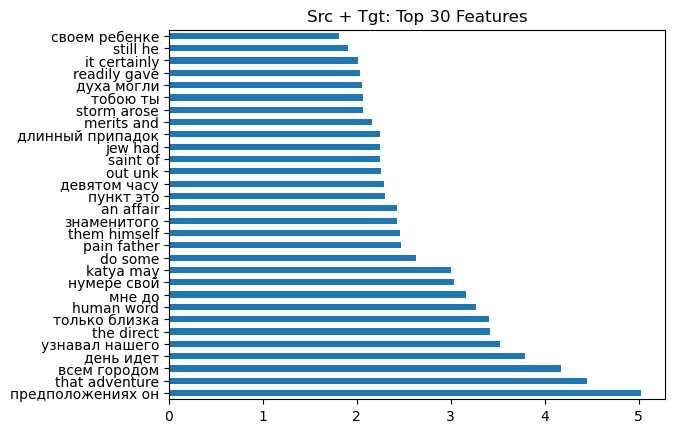

In [36]:
pd.Series(abs(clf_concat.coef_.toarray()[0]), index=tfidf_tok_concat.vocabulary_).nlargest(30).plot(kind='barh', title='Src + Tgt: Top 30 Features')